In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [2]:
using Revise
using Plots
using MCMCChains
using StatsPlots

In [3]:
includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_steps.jl")
includet("gibbs_sampler.jl")
includet("gibbs_var_steps.jl")

In [90]:
    true_var_coeff = [.3 .1;  .4 .6]
    true_trend_covariance =  diagm([.02/10, .01/10] .^2) 

    p = -0.7 * .015 * 0.011

    true_cycle_covariance = [(.015)^2 p
                             p (.011)^2]

     
    true_initial_trend_mean = [.02, .01]
    true_initial_trend_covariance = Matrix(I, 2,2)
    true_initial_cycle_mean = [.0, .0]
    true_initial_cycle_covariance = [(.015)^2 0
                                      0 (.011)^2]
                                   
    
    true_model = tc_var(true_var_coeff, 
                        true_trend_covariance, 
                        true_cycle_covariance, 
                        true_initial_trend_mean, 
                        true_initial_cycle_mean, 
                        true_initial_trend_covariance, 
                        true_initial_cycle_covariance)


    initial_state = [.02, .008]
    true_states, observations= sample(true_model,  [.02, .01, .0, .0], 100)

    n_presample = 20

    presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

    true_states = true_states[n_presample+1:end,:]
 
  

80×4 Matrix{Float64}:
  0.018163     0.00576313  -0.0384094    0.0279798
  0.0206179    0.00503142  -0.00995621  -0.00522151
  0.0231718    0.00504305  -0.0242507    0.00787458
  0.0213089    0.00576715   0.0203675   -0.0154825
  0.0248457    0.00657512   0.00155549   0.00190072
  0.0250333    0.00527256  -0.0113607    0.0119588
  0.0237084    0.00645191  -0.0080752   -0.00948329
  0.0213908    0.00571001   0.00376916  -0.00629464
  0.0198266    0.00472387   0.00668087  -0.00413999
  0.0218788    0.00485073  -0.0041016   -0.00783819
  ⋮                                     
  0.00744069   0.00624102  -0.0378493    0.0133612
  0.00585354   0.00534966  -0.00115428  -0.0172555
  0.00486371   0.00367048  -0.00267357   0.00540389
  0.000860708  0.00323686   0.00999705  -0.0141396
 -0.00211788   0.00456046   0.00434072  -0.00941256
 -0.0014295    0.00378794  -0.0150568    0.000829481
  0.00170388   0.00378053  -0.0225047    0.0154749
 -0.00168387   0.00572052   8.66791e-5   0.000515995
 -0.00

In [91]:
display(mean(presample_data[:,1], dims=1)[1])
display(mean(presample_data[:,2] - presample_data[:,1], dims=1)[1])
display(std(presample_data, dims=1))

0.016339562184962096

0.004977545676998606

1×2 Matrix{Float64}:
 0.0143779  0.0139424

In [92]:
mean(data, dims=1)

1×2 Matrix{Float64}:
 0.0107671  0.0209057

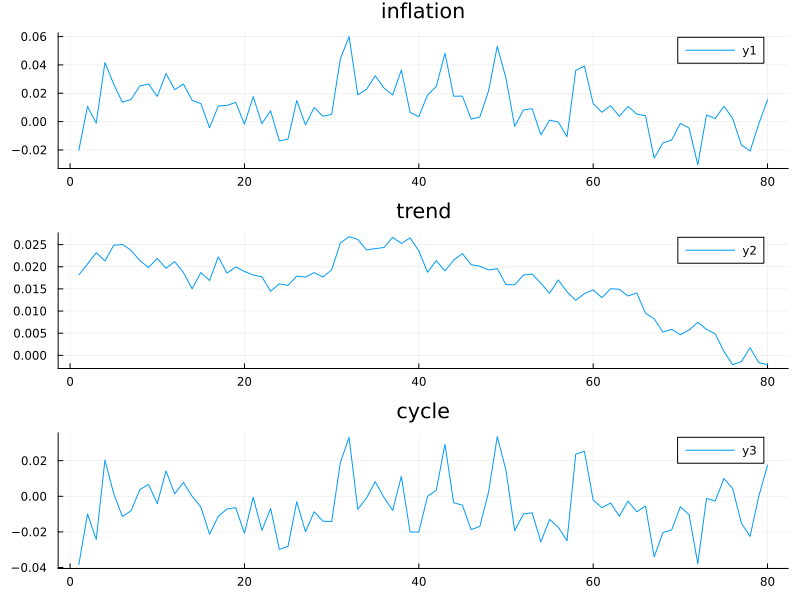

In [93]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

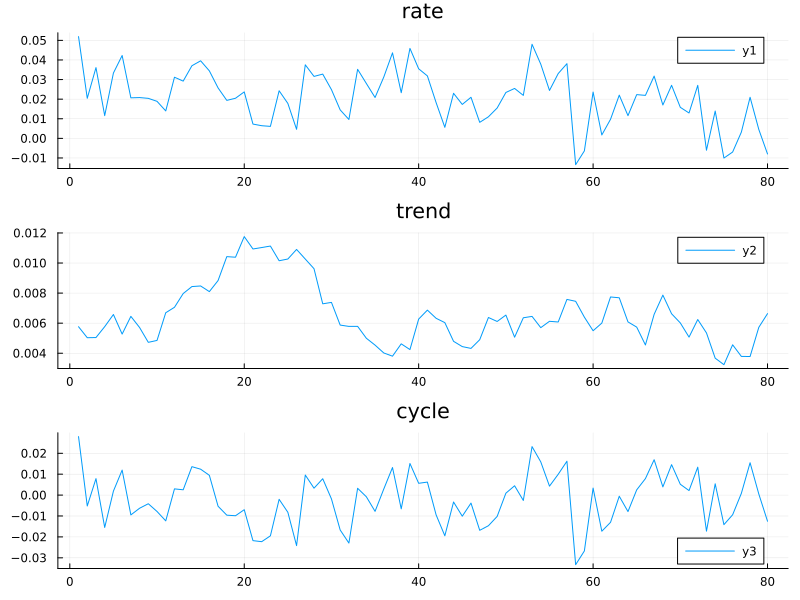

In [94]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [95]:
var(presample_data, dims=1)[1,:]

2-element Vector{Float64}:
 0.00020672482162164394
 0.00019439006060966604

In [96]:
#TODO wyprowadzić wartości do zmiennych, mnożenie razy skale przeniesc do samplera

kτ = 100
kc = 4 #n variables + 2
priors = (
        initial_trend_mean = [mean(presample_data[:,1], dims=1)[1], mean(presample_data[:,2] - presample_data[:,1], dims=1)[1]],
        initial_cycle_mean = zeros(2),
        initial_trend_covariance = diagm([.01, .01]),
        trend_covariance_df = kτ,
        trend_covariance_mean = true_trend_covariance * (kτ + 2 +1),
        cycle_coeff_mean = zeros(2, 2),
        cycle_coeff_shrinkage_param = .2,
        cycle_covariance_scale = diagm(var(presample_data, dims=1)[1,:] * (kc + 2 +1 )), #kc + n_cycle observations + 1
        cycle_covariance_df = kc
      
        )

(initial_trend_mean = [0.016339562184962096, 0.004977545676998606], initial_cycle_mean = [0.0, 0.0], initial_trend_covariance = [0.01 0.0; 0.0 0.01], trend_covariance_df = 100, trend_covariance_mean = [0.000412 0.0; 0.0 0.000103], cycle_coeff_mean = [0.0 0.0; 0.0 0.0], cycle_coeff_shrinkage_param = 0.2, cycle_covariance_scale = [0.0014470737513515076 0.0; 0.0 0.0013607304242676623], cycle_covariance_df = 4)

In [97]:
state_smoothed_samples, trend_covariance_samples, betas_samples, sigmas_samples = gibs_sampler(data, priors; burnin = 25_000, n_samples = 25_000, thin=10)

state_smoothed_mean, state_smoothed_lower, state_smoothed_upper = compute_posterior_statistics(state_smoothed_samples, credible_level=0.95)  

([0.014695604293764196 0.011325195520810733 -0.03493410810715188 0.025864528113750625; 0.014789442834790023 0.01122215366851766 -0.004132048021800187 -0.005591636134111477; … ; -0.004056063438024796 0.009126108409944718 0.002459316659254019 -0.0005198834649470309; -0.003941085282010922 0.009037630165648401 0.0192778545248301 -0.013054205529602835], [0.006196102469934392 0.0007753475178907386 -0.04352391692525562 0.017272210641286263; 0.006475467406292185 0.0008780220908555939 -0.012230433800043822 -0.01325821374290093; … ; -0.011820837123645903 -0.0009214088342861318 -0.00552804792533201 -0.008130592834721985; -0.011965011910977826 -0.0012188144651458829 0.010937251554958314 -0.021443261002950534], [0.02329080244294046 0.02146663368365098 -0.02643779803286339 0.034683788189296516; 0.022893055570490872 0.02114371265252473 0.004125981123327004 0.002452680977096307; … ; 0.003933142550090448 0.019367474674371117 0.01022232202320697 0.006896255633752052; 0.004376674108851304 0.0198104742816

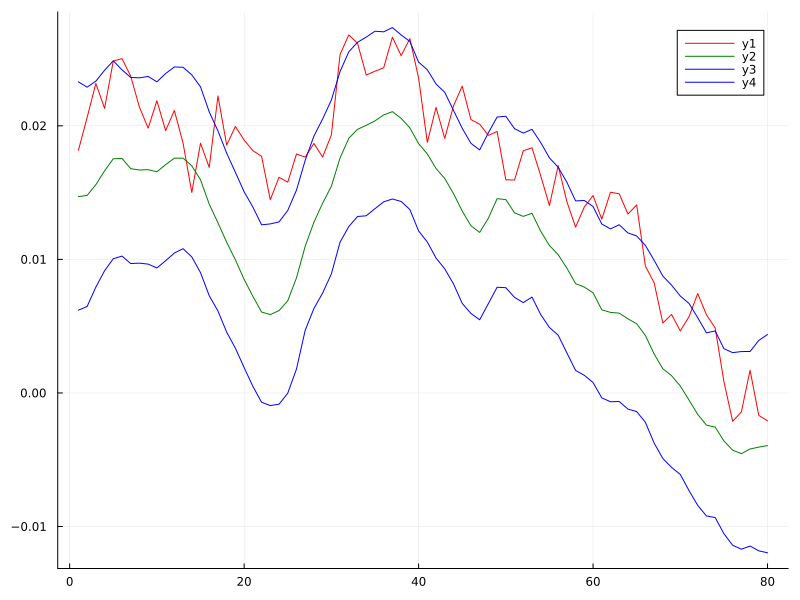

In [98]:
st = 1
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

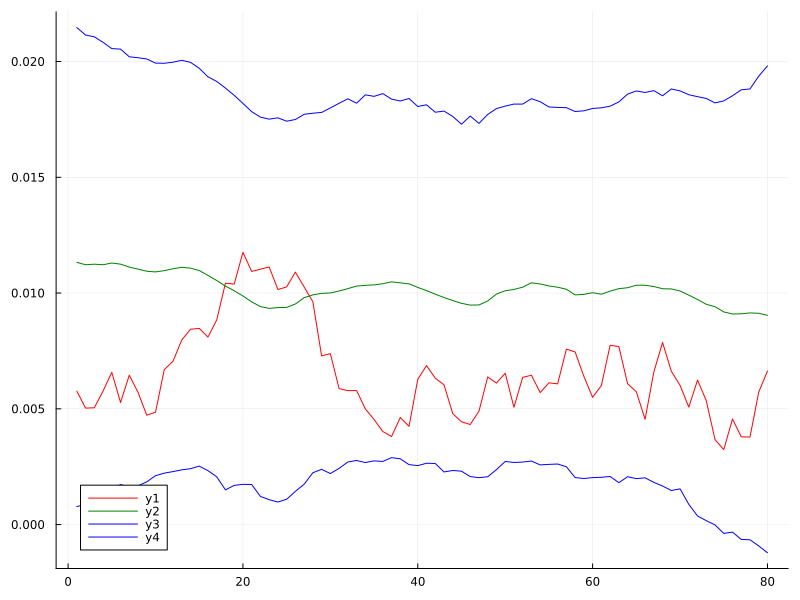

In [99]:
st = 2
plot(true_states[:,st]; color="red", size= (800, 600))
plot!(state_smoothed_mean[:,st], color="green" )
plot!(state_smoothed_lower[:,st], color="blue")
plot!(state_smoothed_upper[:,st], color="blue")

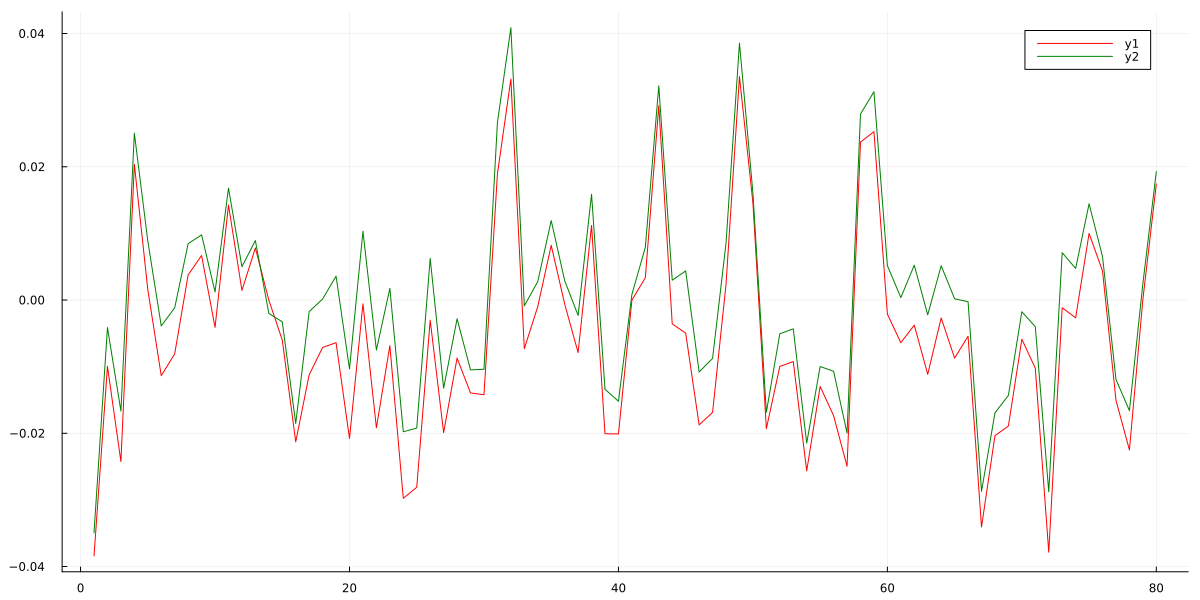

In [100]:
st = 3
plot(true_states[:,st]; color="red", size= (1200, 600))
plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

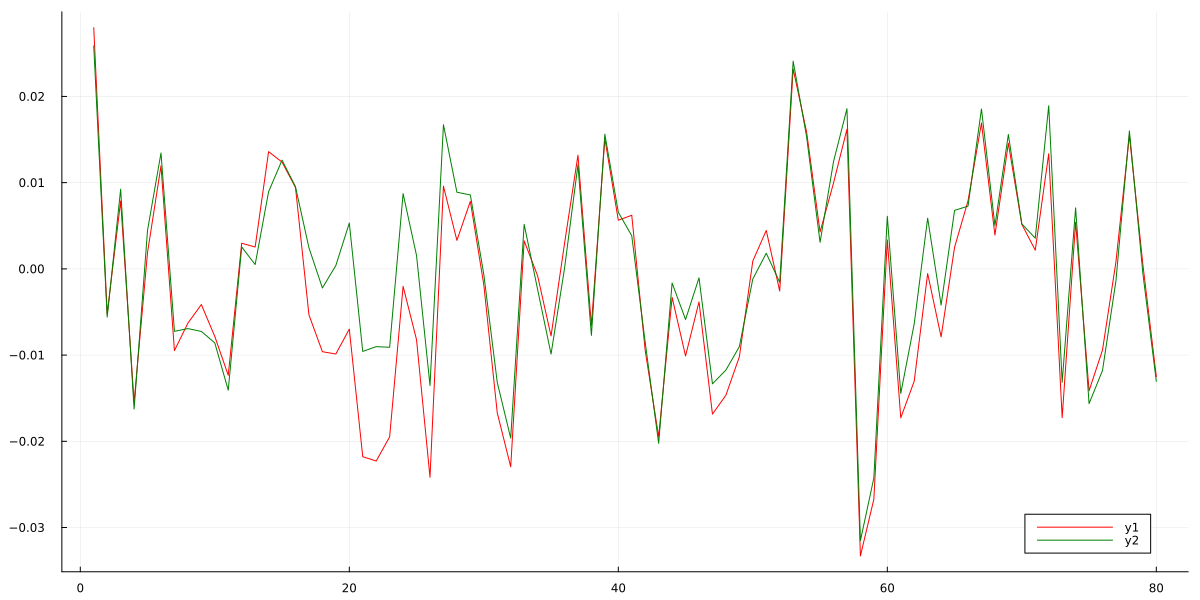

In [101]:
st = 4
plot(true_states[:,st]; color="red", size= (1200, 600))

plot!(state_smoothed_mean[:,st], color="green" )
#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

In [102]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e * 1/(size(Y,1)-1)
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 5.269769133058871e-6
 9.470611696597026e-7

2-element Vector{Float64}:
 0.0022955977724895254
 0.0009731706785860857

In [103]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       Στ[1]    0.0000    0.0000    0.0000   2448.1717   2469.6529    1.0010   ⋯
       Στ[2]    0.0000    0.0000    0.0000   2481.7908   2595.4662    0.9996   ⋯
       Στ[3]    0.0000    0.0000    0.0000   2481.7908   2595.4662    0.9996   ⋯
       Στ[4]    0.0000    0.0000    0.0000   2323.6561   2263.2707    1.0014   ⋯
                                                                1 column omitted


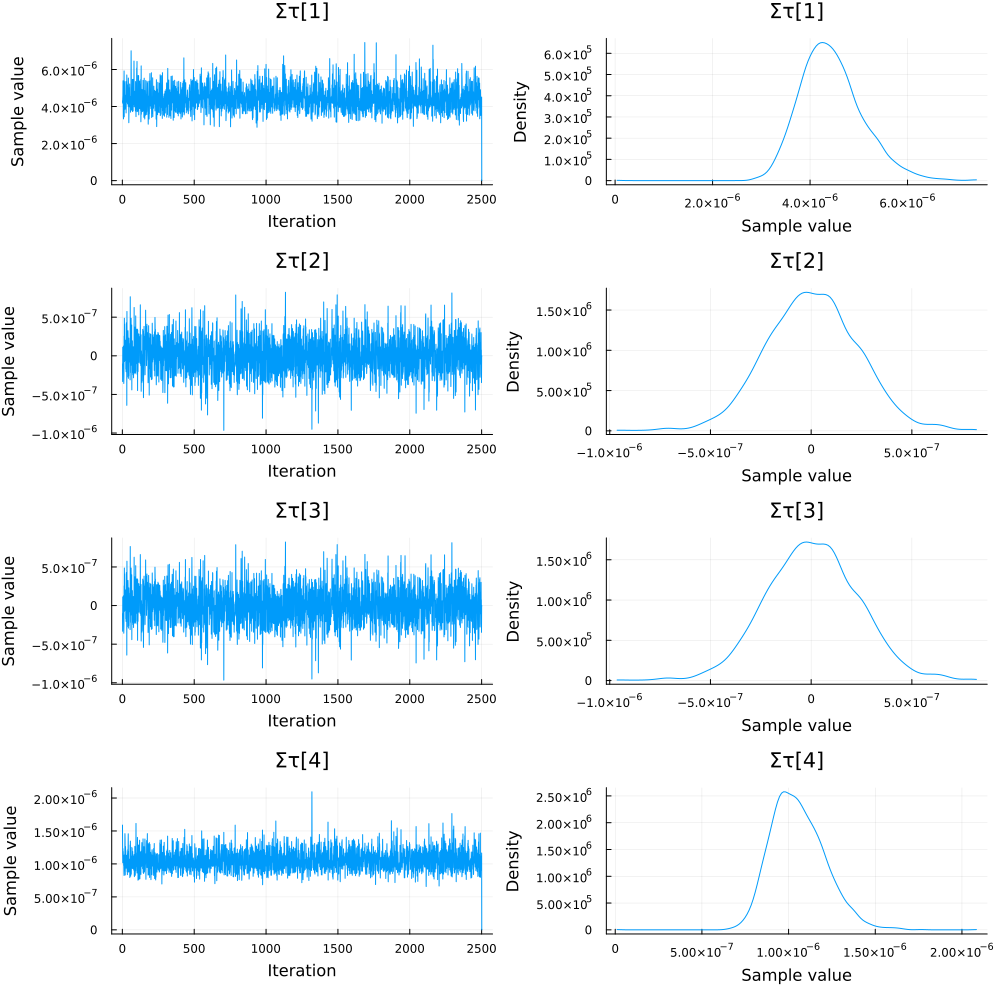

In [104]:
plot(trend_covariance_samples)

In [105]:
display(true_var_coeff)
summarystats(betas_samples)

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

          β1    0.0808    0.0681    0.0014   2534.2777   2419.9301    0.9998   ⋯
          β2   -0.0676    0.0727    0.0014   2656.9789   2378.5748    1.0010   ⋯
          β3    0.0037    0.0556    0.0011   2385.6011   2419.9301    0.9997   ⋯
          β4    0.0488    0.0608    0.0012   2484.9561   2433.8023    0.9997   ⋯
                                                                1 column omitted


In [106]:
display(true_cycle_covariance)
summarystats(sigmas_samples)

2×2 Matrix{Float64}:
  0.000225   -0.0001155
 -0.0001155   0.000121

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       Σc[1]    0.0002    0.0000    0.0000   2354.4384   2362.3387    1.0001   ⋯
       Σc[2]   -0.0001    0.0000    0.0000   2022.1226   2349.7360    1.0009   ⋯
       Σc[3]   -0.0001    0.0000    0.0000   2022.1226   2349.7360    1.0009   ⋯
       Σc[4]    0.0002    0.0000    0.0000   2204.1461   2455.3624    1.0000   ⋯
                                                                1 column omitted


In [61]:
beta_mean_prior, beta_var_prior = minnesota_priors([0.015, 0.011] .^.5 , λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])


([0.0, 0.0, 0.0, 0.0], [0.04000000000000001, 0.029333333333333347, 0.05454545454545455, 0.04000000000000001])

In [62]:
d_post = size(data, 1) - 1 + priors.trend_covariance_df

post_dist = covariance_posterior(true_states[:,[1,2]], priors.trend_covariance_mean, d_post)

InverseWishart{Float64, PDMats.PDMat{Float64, Matrix{Float64}}}(
df: 1599.0
Ψ: [0.0064777840682630795 -0.00016922782812739; -0.00016922782812739 0.0015876091751548303]
)


In [63]:
true_var + priors.trend_covariance_mean

2×2 Matrix{Float64}:
  0.000416047  -1.12894e-7
 -1.12894e-7    0.00010399

In [64]:
cov_posterior = zeros(10_000, 2)

for n in 1:10_000
  cov_posterior[n,:,:] = diag(rand(post_dist))
end


display(mean(cov_posterior, dims=1) .* 100)
display(mean(cov_posterior, dims=1).^.5 *10) 
display(mode(cov_posterior[1]).^.5 * 10) 
display(mode(cov_posterior[2]).^.5 * 10) 

1×2 Matrix{Float64}:
 0.000405957  9.94743e-5

1×2 Matrix{Float64}:
 0.0201484  0.00997368

0.020104675994817595

0.020417260219856428

In [65]:
diag(true_trend_covariance) .^.5 * 10

2-element Vector{Float64}:
 0.02
 0.01

In [66]:
true_trend_covariance .^.5 .*10

2×2 Matrix{Float64}:
 0.02  0.0
 0.0   0.01

In [67]:
diag(priors.trend_covariance_mean) .^.5 *10

2-element Vector{Float64}:
 0.20297783130184438
 0.10148891565092219

In [68]:
stds = zeros(50_000, 2)


for n in 1:50_000
    stds[n,:] = diag(rand(InverseWishart(priors.trend_covariance_df, priors.trend_covariance_mean)))
end

display(mean(stds, dims=1).^.5 .*10)
display(mode(stds[1]) ^.5 * 10) 
display(mode(stds[2]) ^.5 * 10) 


1×2 Matrix{Float64}:
 0.0206139  0.0103075

0.021347686700771765

0.01865573986789668

In [69]:
stds = std.(eachcol(true_states[:,[3, 4]]))

2-element Vector{Float64}:
 0.015995571627785244
 0.013333151028258447

In [27]:
stds[2]/stds[1] * 0.2

0.16842664811164693

In [70]:
φ, Ω =  minnesota_priors([.015, .011], λ1=0.2, λ2=1., λ3=1.0, p=1, zero_ownlag=[true, true])

display(reshape(φ, 2, 2))

Ω

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0

4-element Vector{Float64}:
 0.04000000000000001
 0.021511111111111113
 0.07438016528925621
 0.04000000000000001

In [71]:
(1 ./ Ω)' *  Ω

4.0

In [72]:
true_var_coeff

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

In [73]:
Y, X = prepare_var_data(true_states[:, [3,4]], 1)

(inv(X'X)*X'*Y)'

2×2 adjoint(::Matrix{Float64}) with eltype Float64:
 0.249427  0.0660376
 0.419512  0.618132

In [74]:
posterior_beta_coefficient(Y, X, reshape(φ, 2, 2), reshape((1 ./ Ω), 2, 2))'

UndefVarError: UndefVarError: `posterior_beta_coefficient` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [33]:
posterior_beta_coefficient(Y, X, reshape(φ, 2, 2), zeros(2,2))'

UndefVarError: UndefVarError: `posterior_beta_coefficient` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [95]:
display(true_var_coeff)
display(true_cycle_covariance)

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

2×2 Matrix{Float64}:
 0.0004  0.0
 0.0     0.0081

In [84]:
T = 1_200

test_var_data = zeros(T, 2)

test_var_data[1,:] = [0., 0.]

for t in 2:T
    test_var_data[t, :] = true_var_coeff * test_var_data[t-1, :] + rand(MvNormal(zeros(2), true_cycle_covariance))
end 

In [91]:
var(test_var_data, dims=1)

1×2 Matrix{Float64}:
 0.000250988  0.00018447

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     param_1    0.2207    0.2642    0.2868    0.3098    0.3557
     param_2   -0.0681   -0.0169    0.0099    0.0359    0.0867
     param_3    0.3267    0.3630    0.3829    0.4003    0.4340
     param_4    0.5481    0.5902    0.6108    0.6322    0.6735


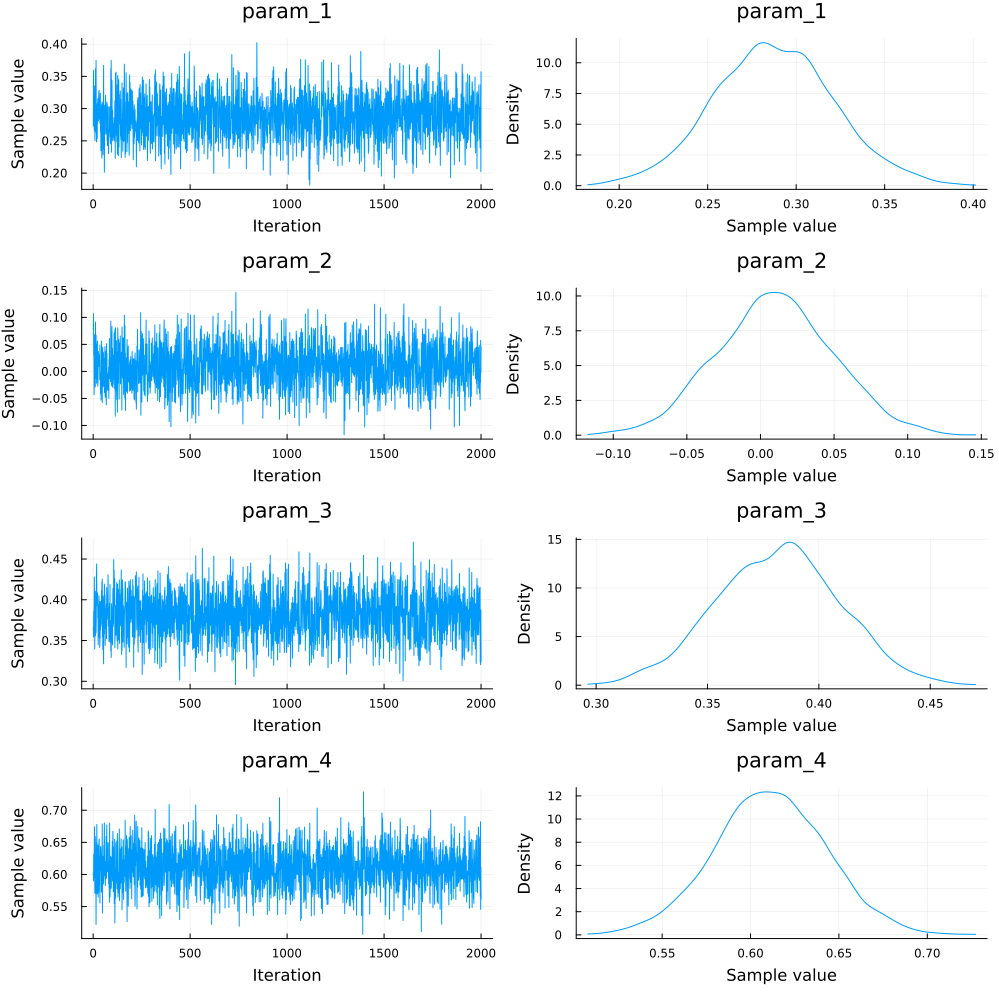

2×2 Matrix{Float64}:
  0.000225   -0.0001155
 -0.0001155   0.000121

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     param_1    0.0002    0.0002    0.0003    0.0003    0.0003
     param_2   -0.0001   -0.0001   -0.0001   -0.0001   -0.0001
     param_3   -0.0001   -0.0001   -0.0001   -0.0001   -0.0001
     param_4    0.0002    0.0002    0.0002    0.0002    0.0002


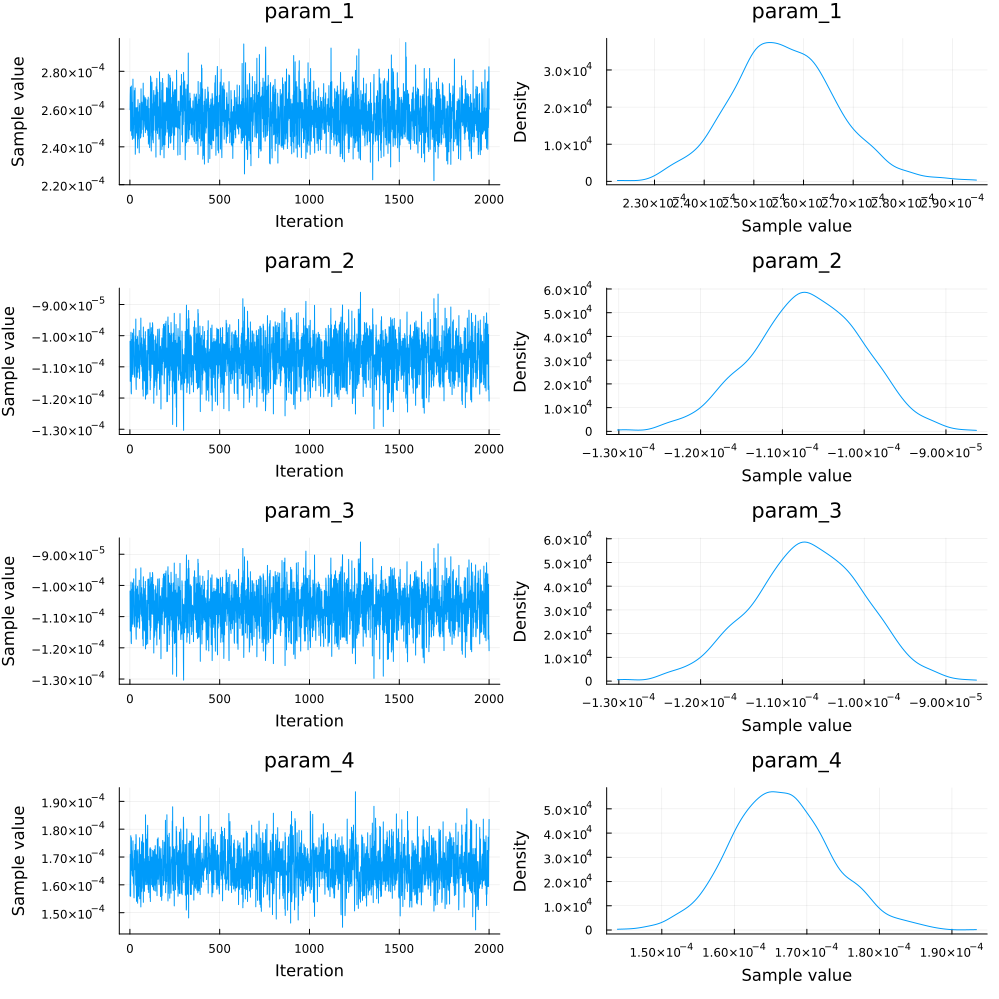

In [ ]:
nc = 2
kc = nc + 2 

variance_prior = (kc + 2 + 1) * [(.015)^2 0
                                 0 (.011)^2
                                ]

λ = .2
Ω = [λ^2, λ^2] ./ diag(prior_var)
Ω = Diagonal(Ω)
Ω_inv = inv(Ω)

n_scenarios = 2_000

betas = zeros(n_scenarios, 4)
sigmas = zeros(n_scenarios, 2, 2)

df = kc + size(test_var_data, 1) - 1

for s in 1:n_scenarios

  betas[s,:], sigmas[s, :, :] = sample_var_params(test_var_data, 1, zeros(2,2), Ω_inv, prior_var, df)
end

chains = Chains(betas)
display(true_var_coeff)
display(quantile(chains))
display(plot(chains))


display(true_cycle_covariance)
chains = Chains(reshape(sigmas, n_scenarios, 4, 1))
display(quantile(chains))

display(plot(chains))

In [99]:
summarystats(chains)

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

     param_1    0.0003    0.0000    0.0000   2136.0656   1962.9117    1.0012   ⋯
     param_2   -0.0001    0.0000    0.0000   2051.3517   1755.8243    1.0005   ⋯
     param_3   -0.0001    0.0000    0.0000   2051.3517   1755.8243    1.0005   ⋯
     param_4    0.0002    0.0000    0.0000   1910.4010   1962.7334    1.0010   ⋯
                                                                1 column omitted


In [107]:
mean(get(chains, :param_1).param_1.data) * 100

0.02561049631556582

In [108]:
mean(get(chains, :param_1).param_1.data)  .^ .5

0.01600327976246301

In [109]:
mean(get(chains, :param_4).param_4.data)  .^ .5

0.012901758315082232

In [110]:
mean(get(chains, :param_4).param_4.data) * 100

0.016645536762079353

uncoditional variance

In [28]:
prior_var_coeff = [0. 0.; 0. 0.]
uv = inv(I(4) - kron(prior_var_coeff, prior_var_coeff)) * vec(true_cycle_covariance)
reshape(uv, 2, 2)

2×2 Matrix{Float64}:
  0.000225   -0.0001155
 -0.0001155   0.000121

In [114]:
kron(I(2), I(2)) * vec(true_cycle_covariance)

4-element Vector{Float64}:
  0.000225
 -0.00011549999999999997
 -0.00011549999999999997
  0.00012099999999999999

In [85]:
uv = inv(I(4) - kron(zeros(2,2), zeros(2,2))) * vec(true_cycle_covariance)

4-element Vector{Float64}:
 0.0004
 0.0
 0.0
 0.0081

In [86]:
kron(zeros(2,2), zeros(2,2))

4×4 Matrix{Float64}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0